In [1]:
import json
import os

RESULTS_DIR = '../experiments/results/'

def read_json(path):
    with open(path, 'r') as f: 
        res = json.load(f)
    return res
tasks = read_json('../experiments/tasks.json')
# results = [read_json(os.path.join(RESULTS_DIR, path)) for path in os.listdir(RESULTS_DIR)]

In [2]:
def query_job_ids(algorithm=None, data_type=None, n_qubits=None):
    filtered_tasks = tasks
    if algorithm is not None:
        filtered_tasks = [task for task in filtered_tasks if task['algorithm']==algorithm]
    if data_type is not None:
        filtered_tasks = [task for task in filtered_tasks if task['data_type']==data_type]
    if n_qubits is not None:
        filtered_tasks = [task for task in filtered_tasks if task['n_qubits']==n_qubits]
    return [t['id'] for t in filtered_tasks if os.path.isfile(os.path.join(RESULTS_DIR, f'{t["id"]}.json'))]

# Графики

* качество lptn от ранга
* качество разных алгоритмов от числа кубит
* время обучения для разных алгоритмов и кубит
* число шагов для разных алгоритмов и кубит
* потребляемая память для разных алгоритмов и кубит
* гистограмма fidelity для lptn

In [3]:
qubits_range = list(range(1,8))

### Качество lptn от ранга

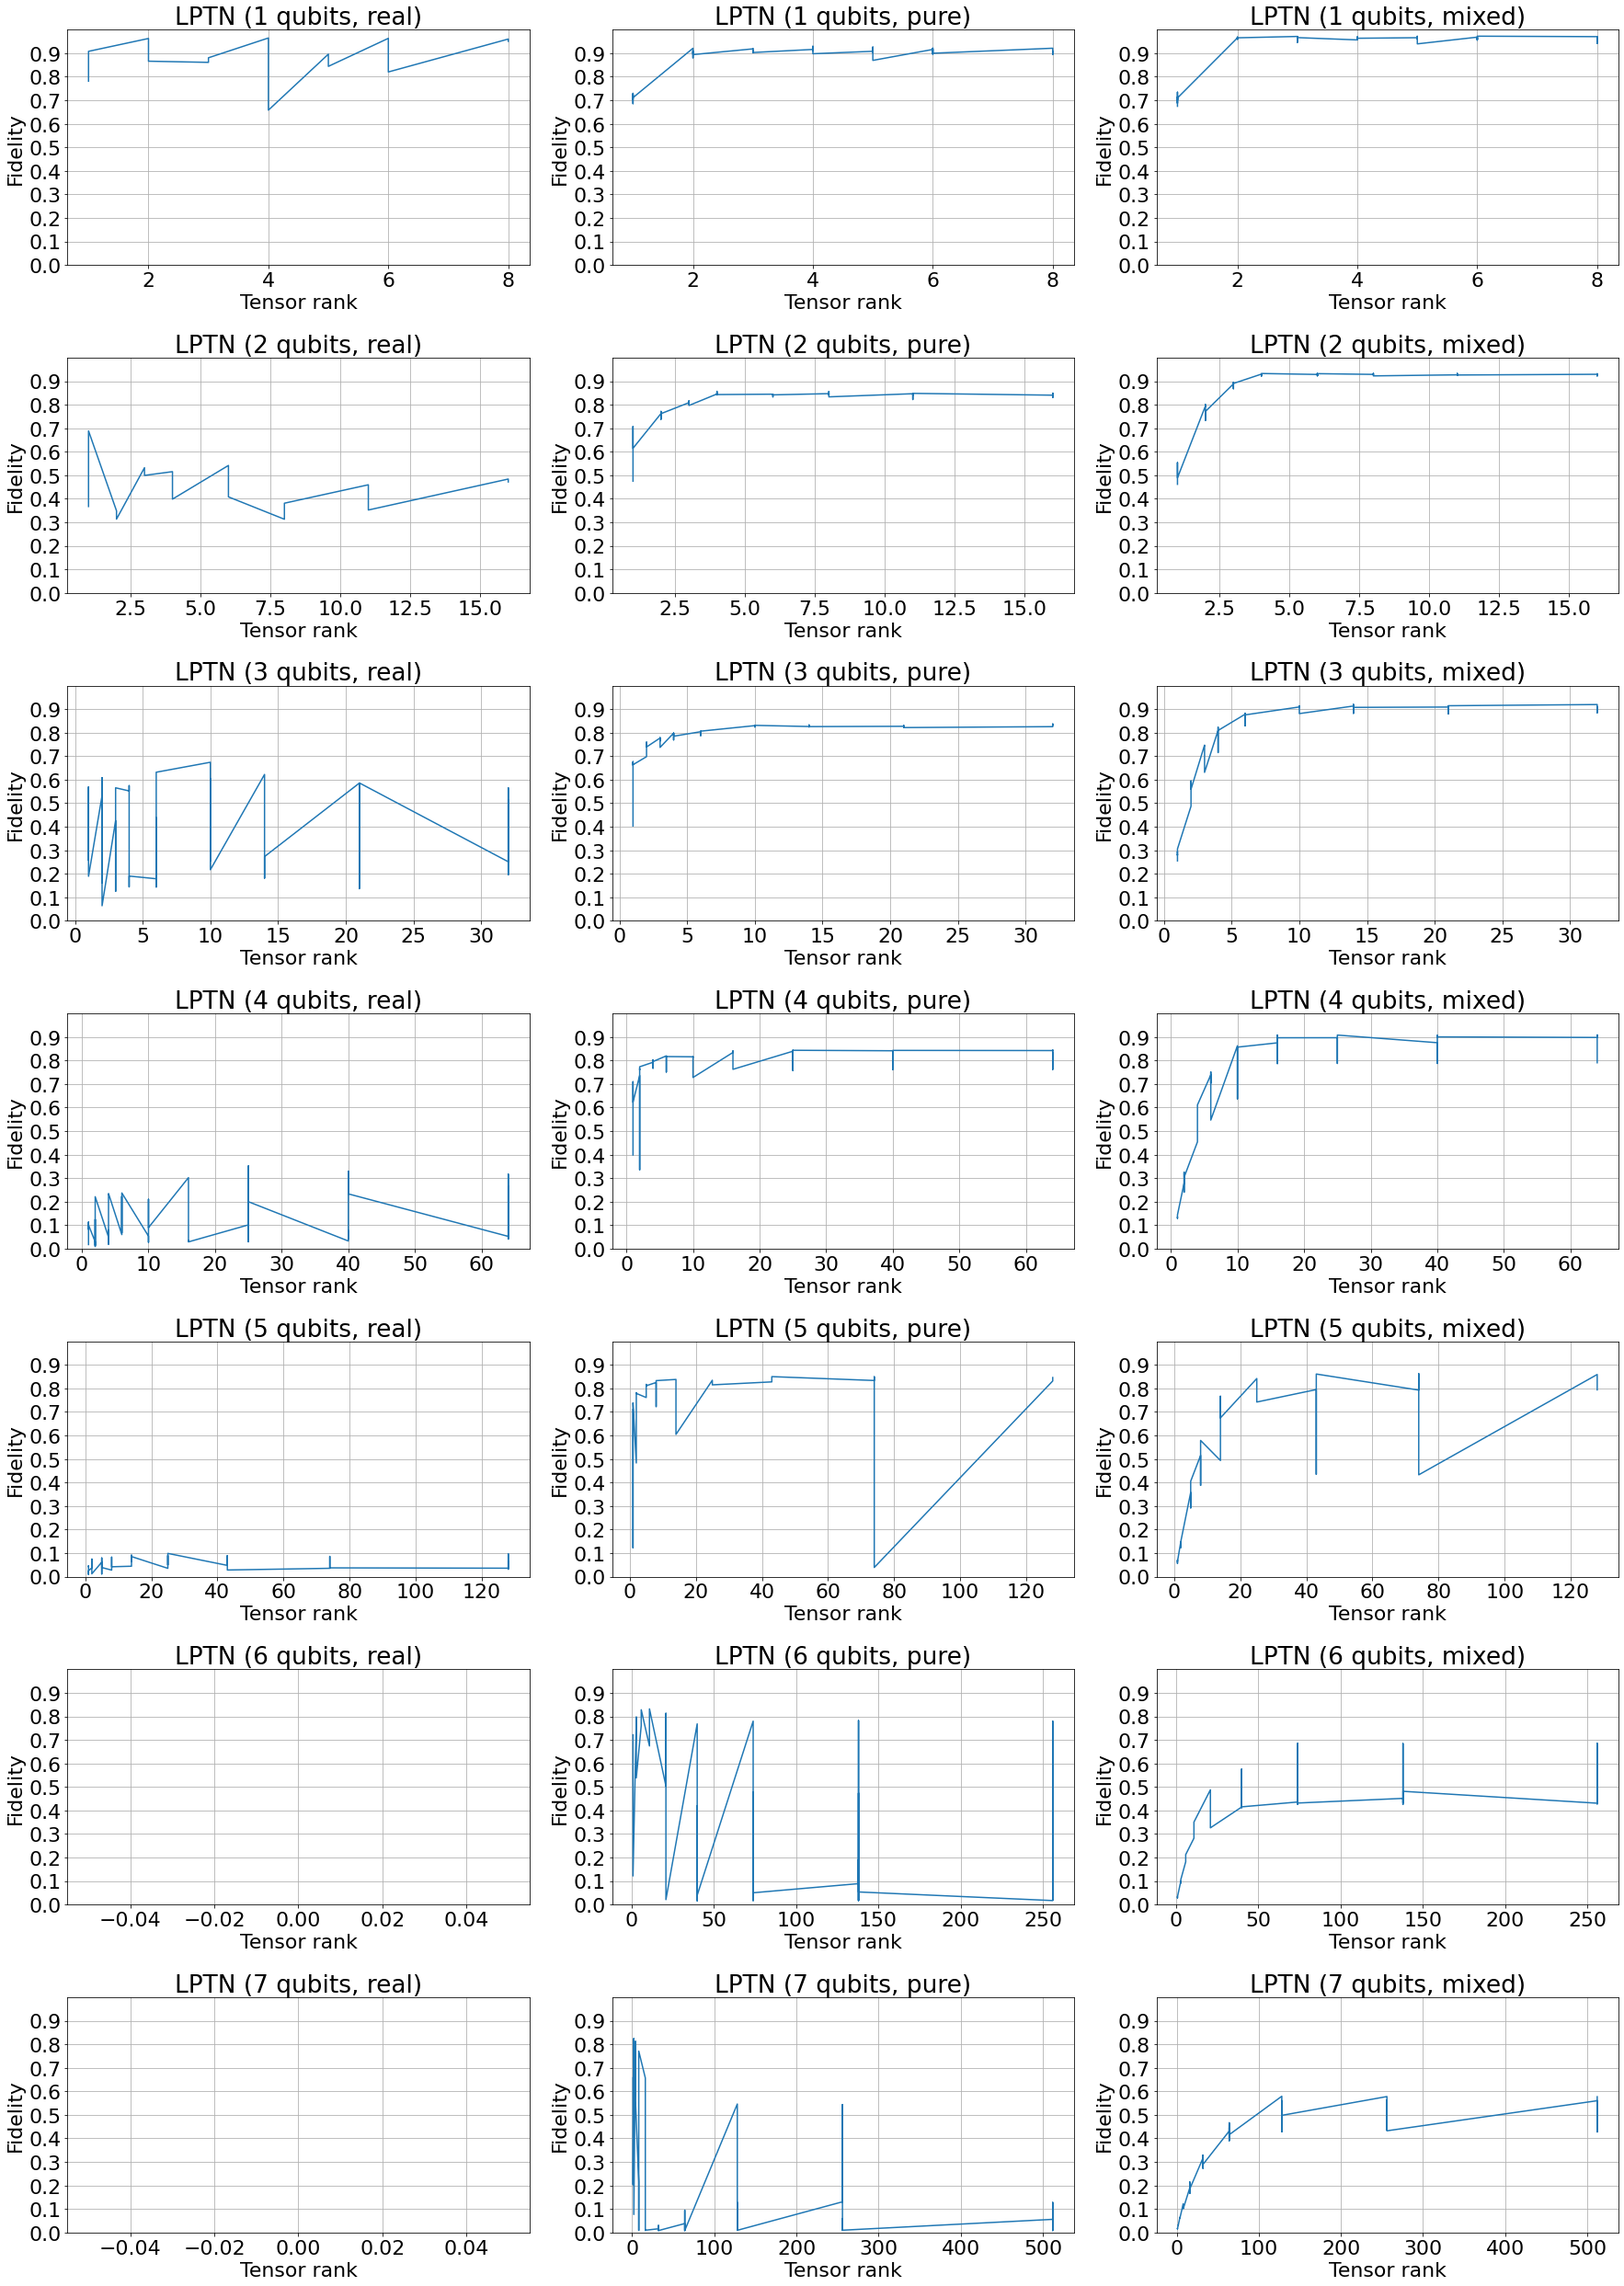

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,5*len(qubits_range)))
plt.rcParams.update({'font.size': 22})


for n_qubits in qubits_range:
    for i, data_type in enumerate(['real', 'pure', 'mixed']):
        plt.subplot(len(qubits_range), 3, 3*(n_qubits - 1) + i+1)
        task_ids = query_job_ids('lptn', data_type, n_qubits)
        tensor_ranks = np.array([tasks[i]['tensor_rank'] for i in task_ids])
        sorted_idx = np.argsort(tensor_ranks)
        fidelities = np.array([np.mean([max(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']]) for tid in task_ids])
        plt.ylabel('Fidelity')
        plt.xlabel('Tensor rank')
        plt.title(f'LPTN ({n_qubits} qubits, {data_type})')
        plt.yticks([0.1*i for i in range(10)])
        plt.ylim((0,1))
        plt.grid()
        plt.plot(tensor_ranks[sorted_idx], fidelities[sorted_idx])
plt.tight_layout()

## Гистограмма fidelity для lptn

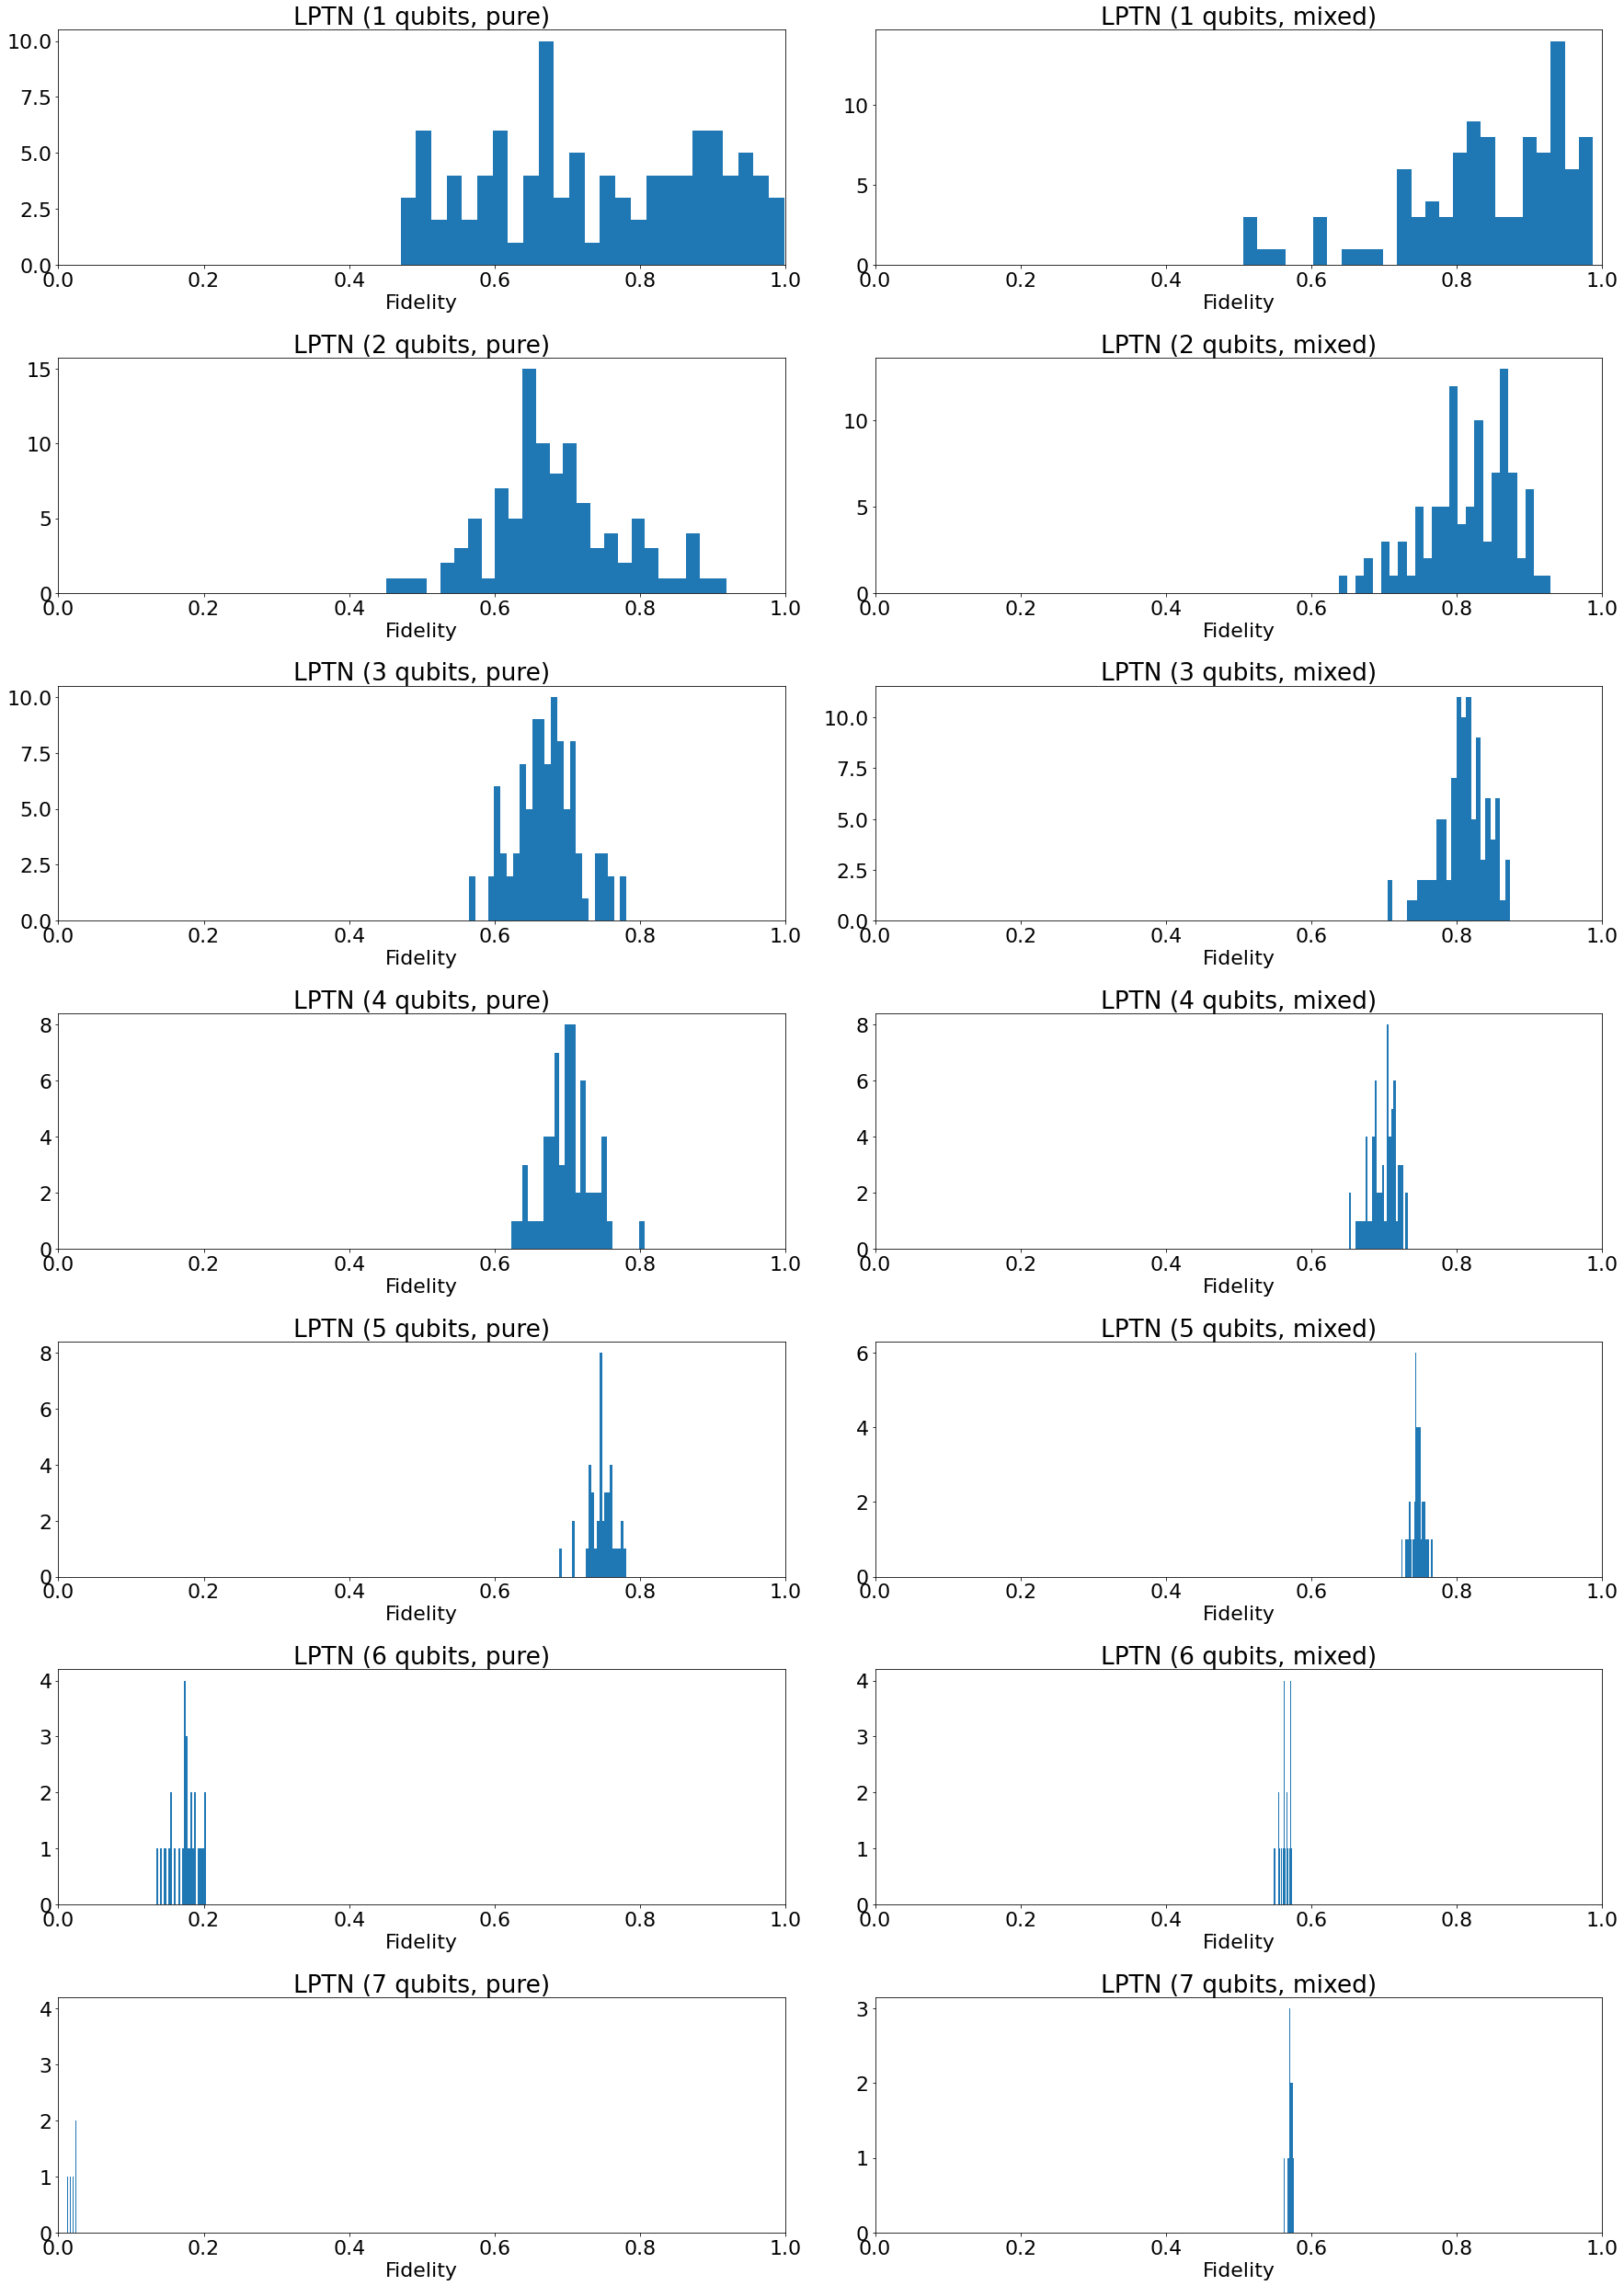

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,5*len(qubits_range)))
plt.rcParams.update({'font.size': 22})


for n_qubits in qubits_range:
    for i, data_type in enumerate(['pure', 'mixed']):
        plt.subplot(len(qubits_range), 2, 2*(n_qubits - 1) + i+1)
        task_ids = query_job_ids('lptn', data_type, n_qubits)
        if len(task_ids) == 0: continue
        tensor_ranks = np.array([tasks[i]['tensor_rank'] for i in task_ids])
        sorted_idx = np.argsort(tensor_ranks)
        fidelities = np.array([[np.mean(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
        fidelities = fidelities[sorted_idx[-1]]
        plt.xlabel('Fidelity')
        plt.title(f'LPTN ({n_qubits} qubits, {data_type})')
        plt.hist(fidelities, bins=25)
        plt.xlim((0,1))
plt.tight_layout()

## Качество разных алгоритмов от числа кубит

In [6]:
qubits_range = list(range(1,6))

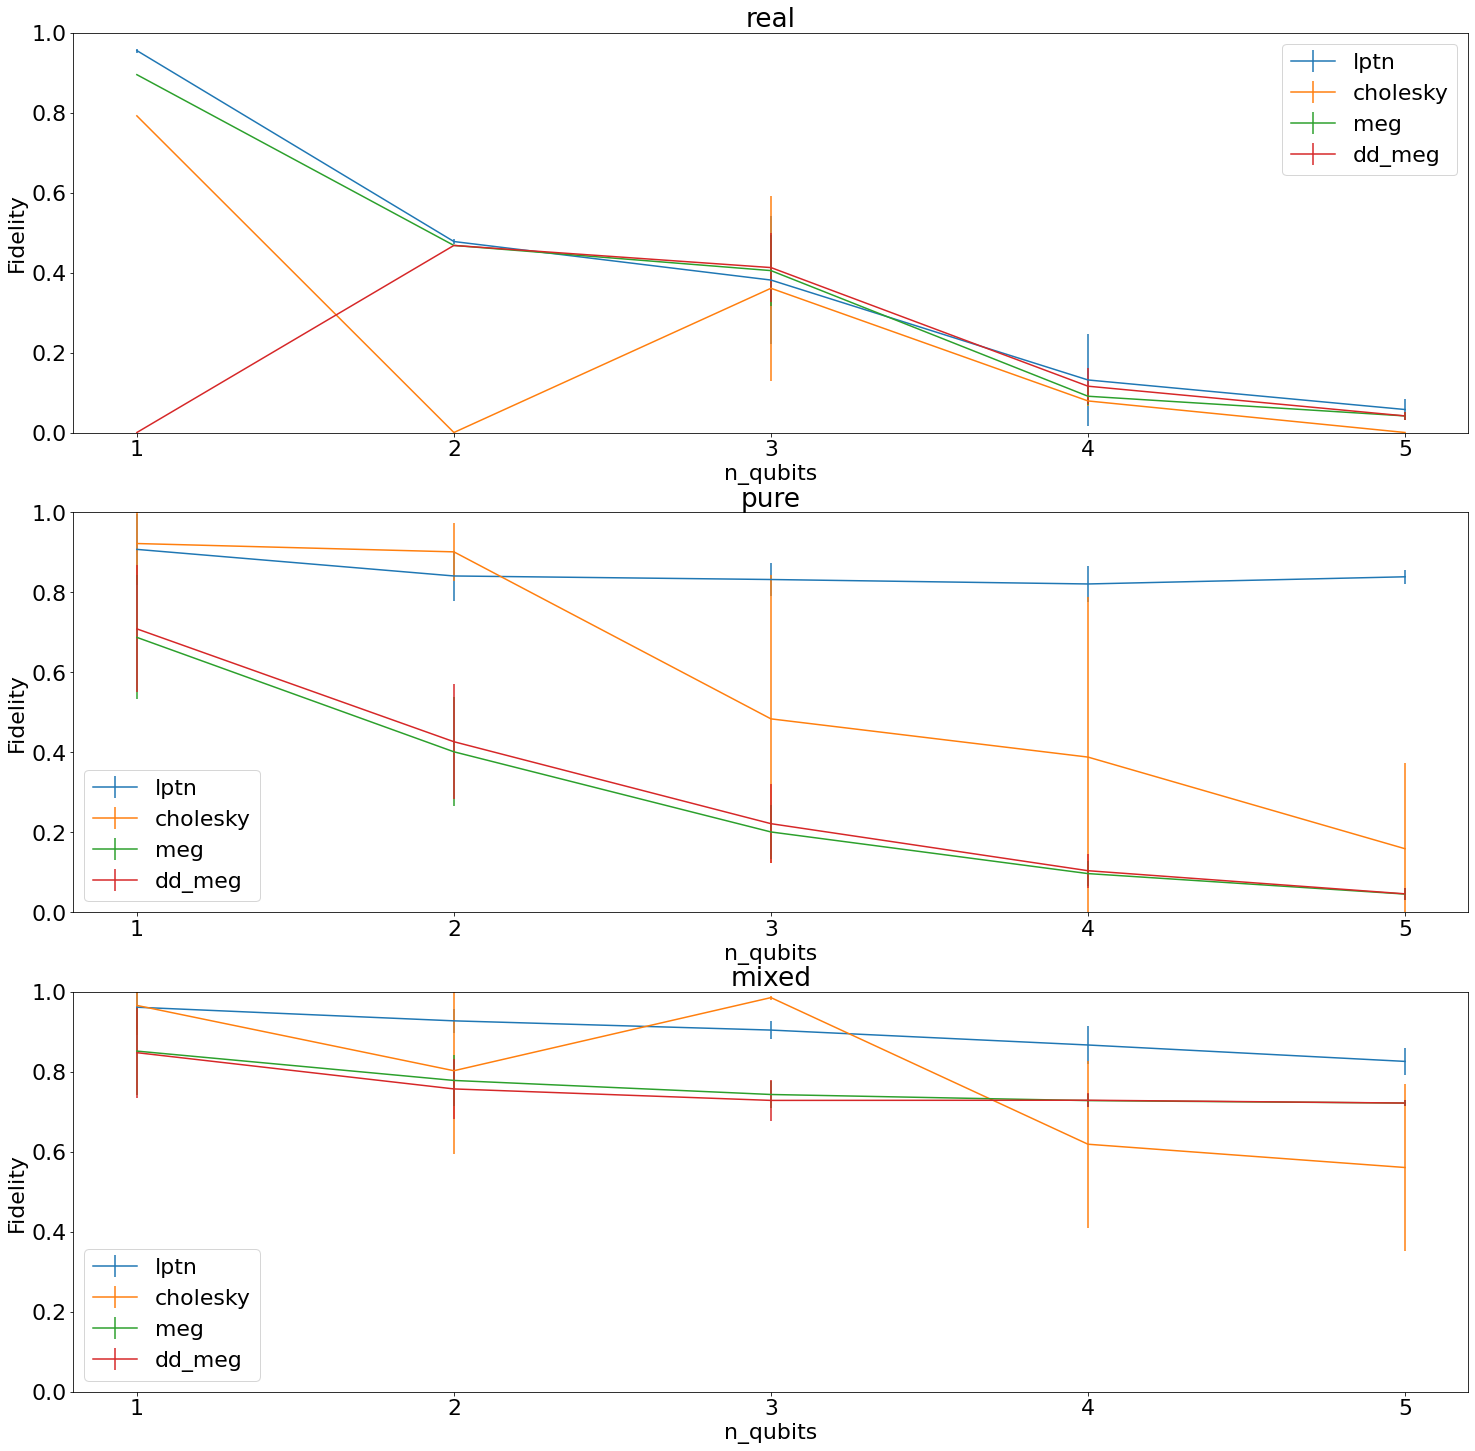

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            fidelities = np.array([[max(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[i]['tensor_rank'] for i in task_ids])
                fidelities = fidelities[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(fidelities), np.std(fidelities)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Fidelity")
        plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

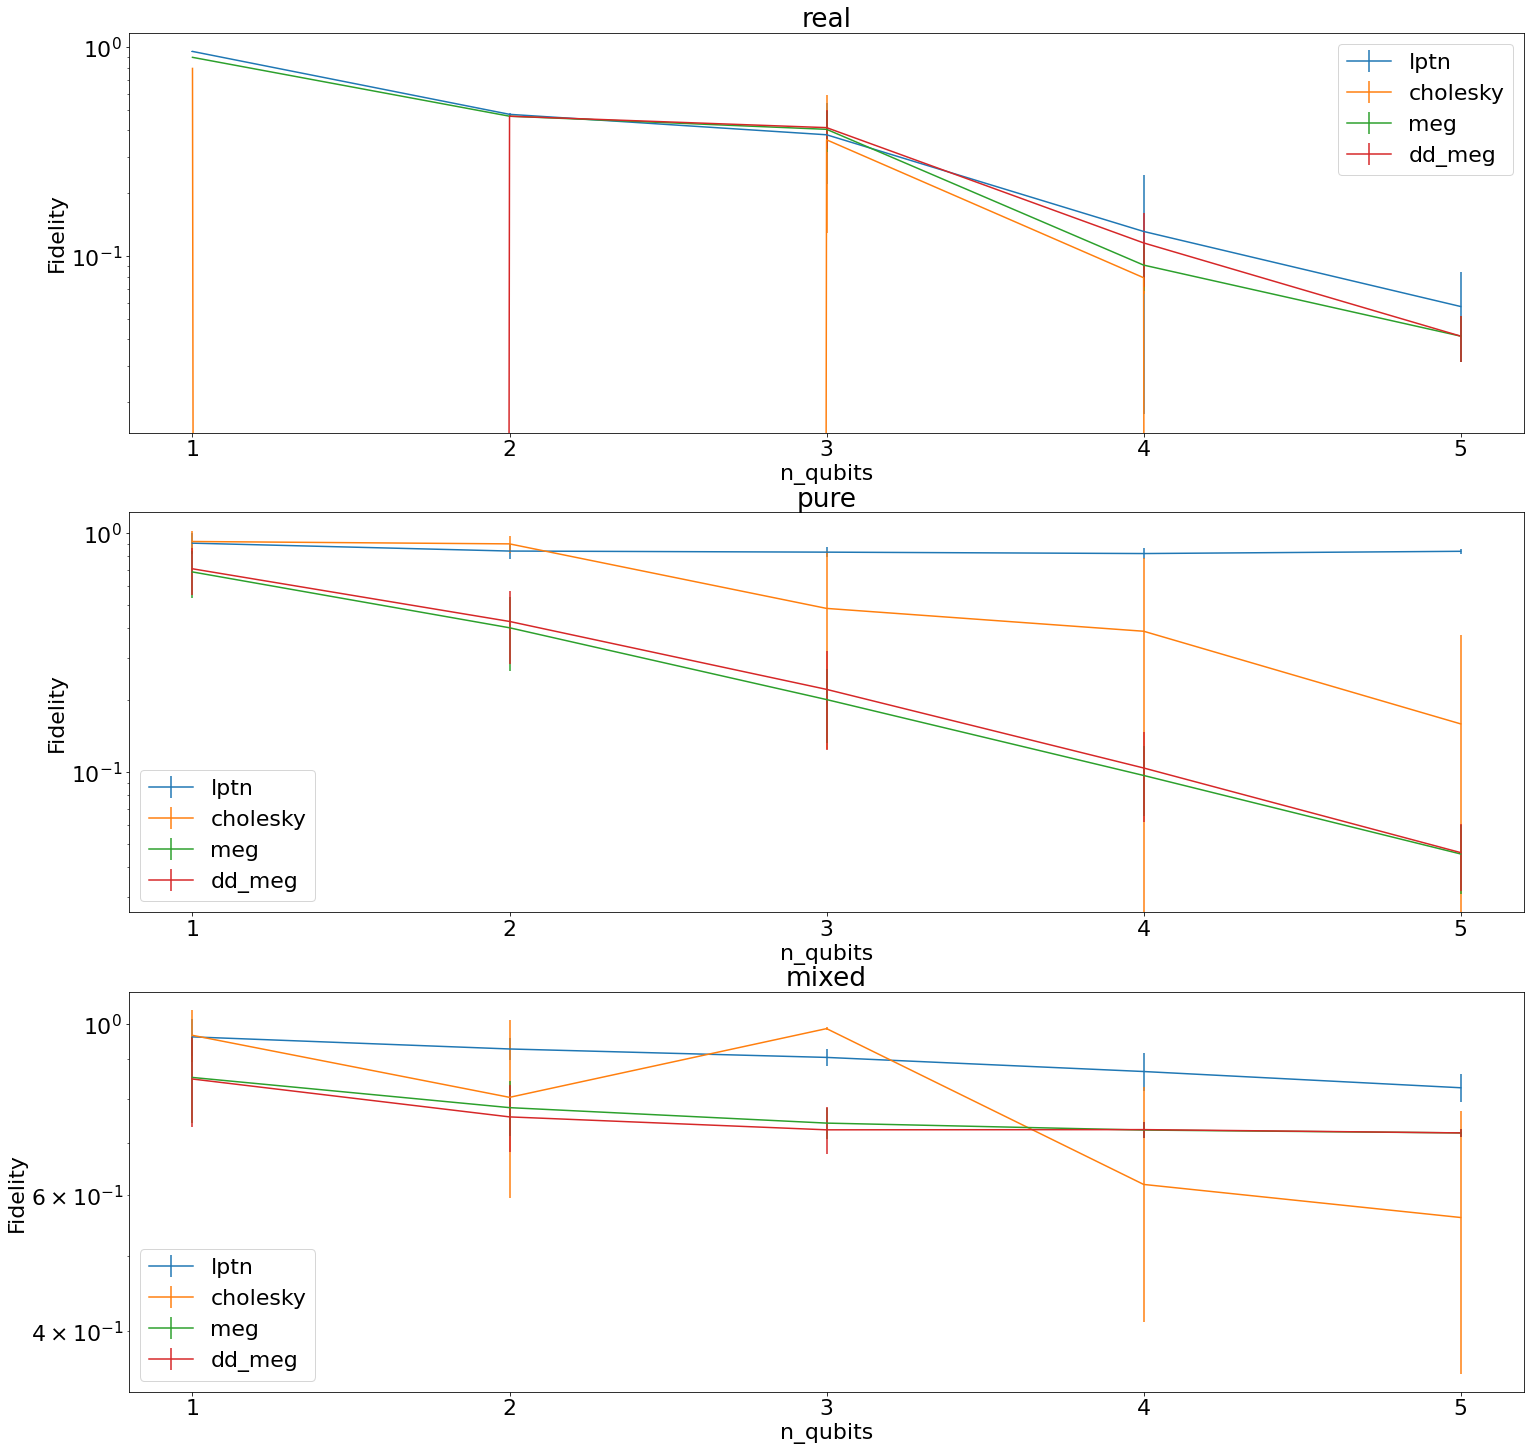

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            fidelities = np.array([[max(x['fidelities']) for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                fidelities = fidelities[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(fidelities), np.std(fidelities)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Fidelity")
#         plt.ylim((0,1))
        plt.yscale('log')
    plt.legend()

## Время обучения для разных алгоритмов и кубит

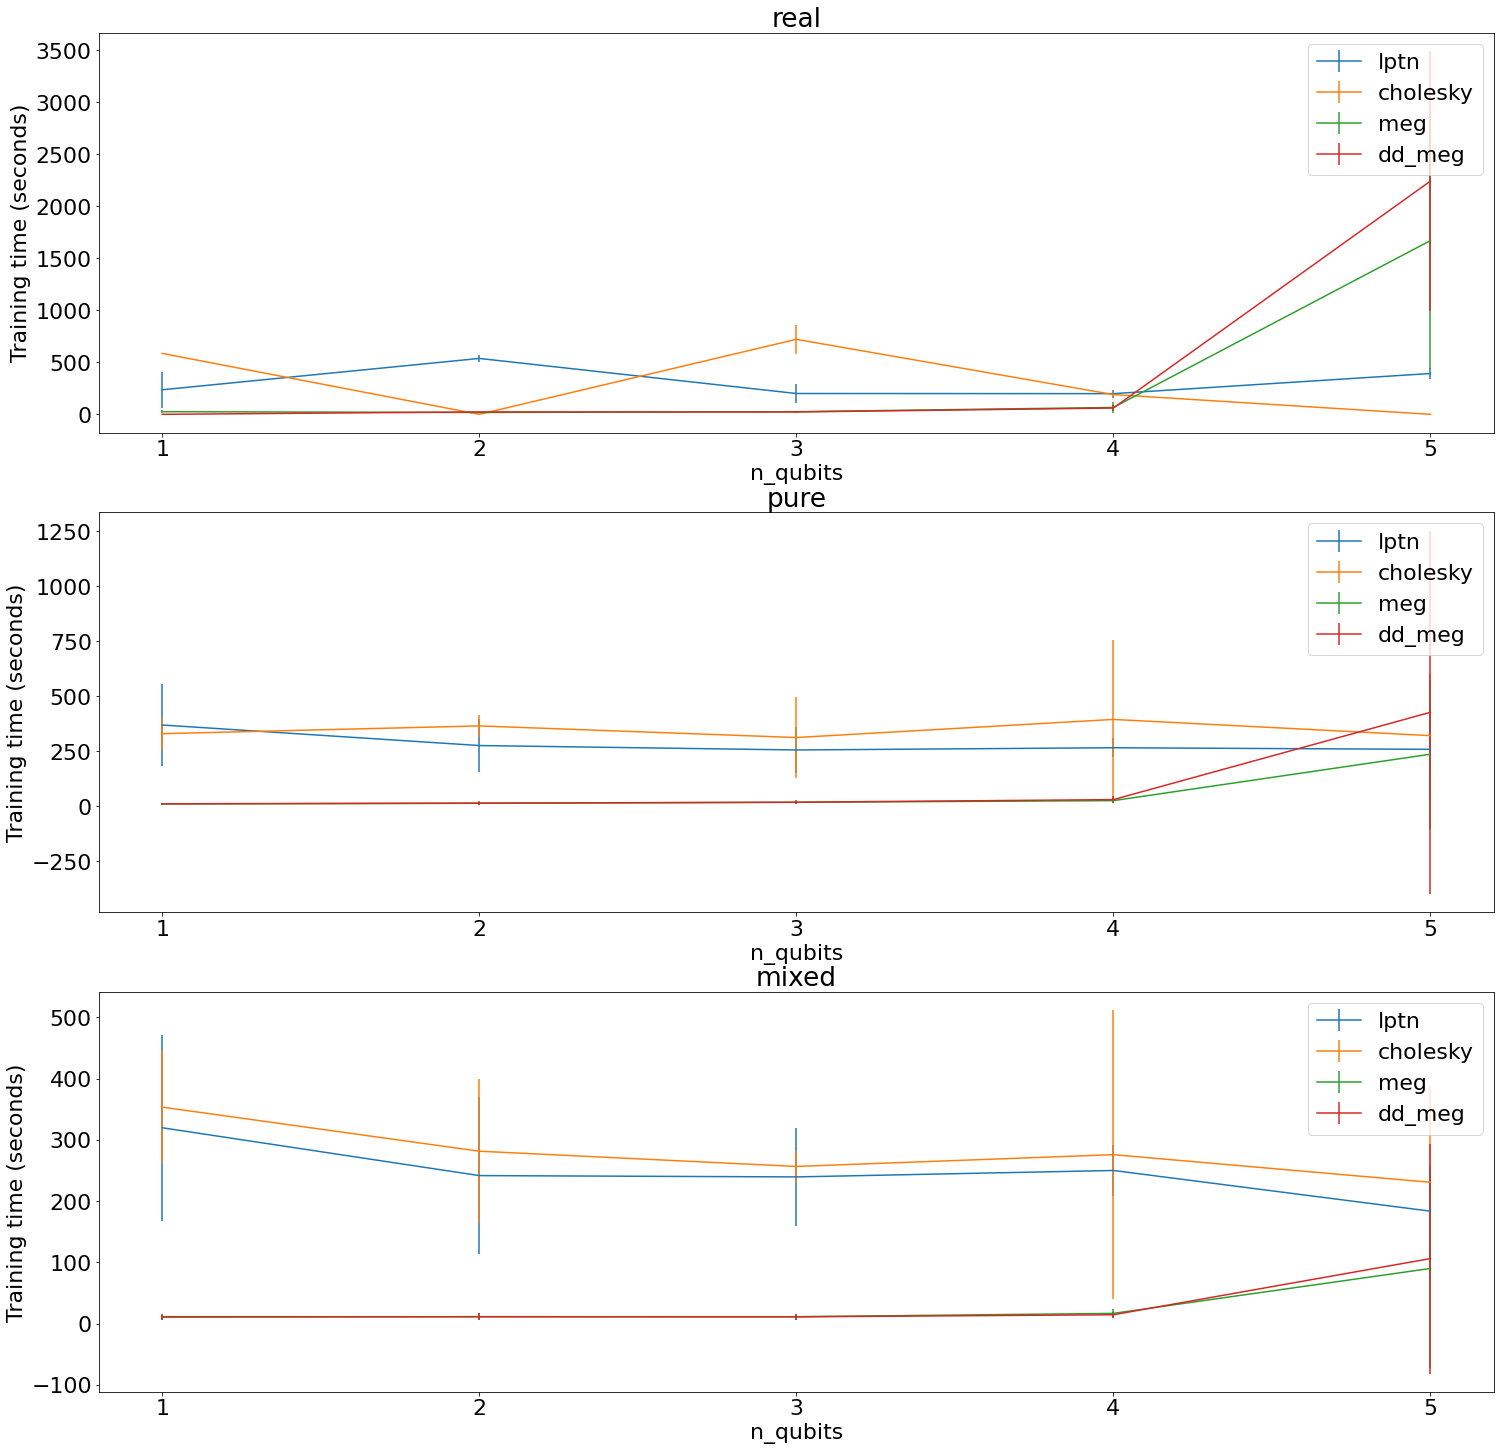

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            training_time = np.array([[x['time'] for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                training_time = training_time[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(training_time), np.std(training_time)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Training time (seconds)")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

## Число шагов для разных алгоритмов и кубит

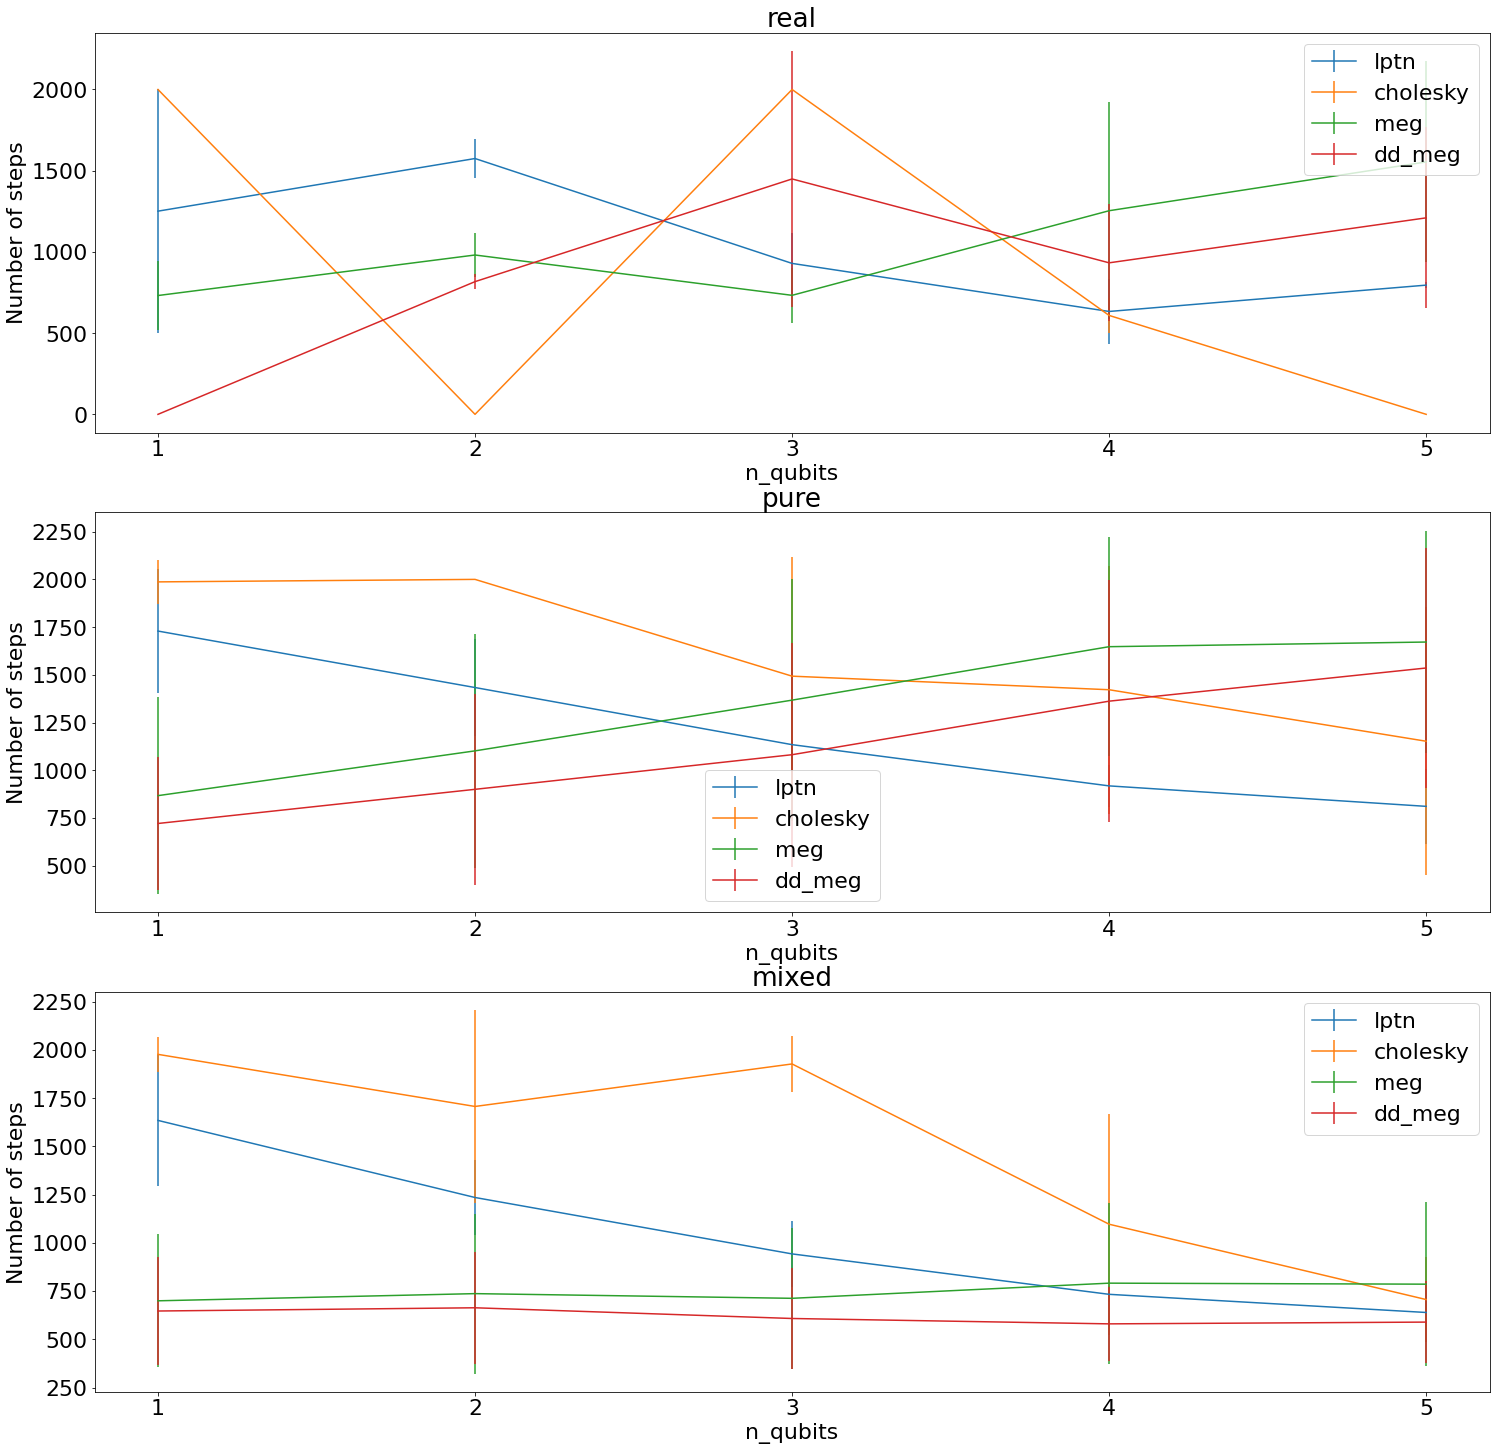

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            num_steps = np.array([[x['num_steps'] for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                num_steps = num_steps[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(num_steps), np.std(num_steps)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("Number of steps")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

## Потребляемая память для разных алгоритмов и кубит

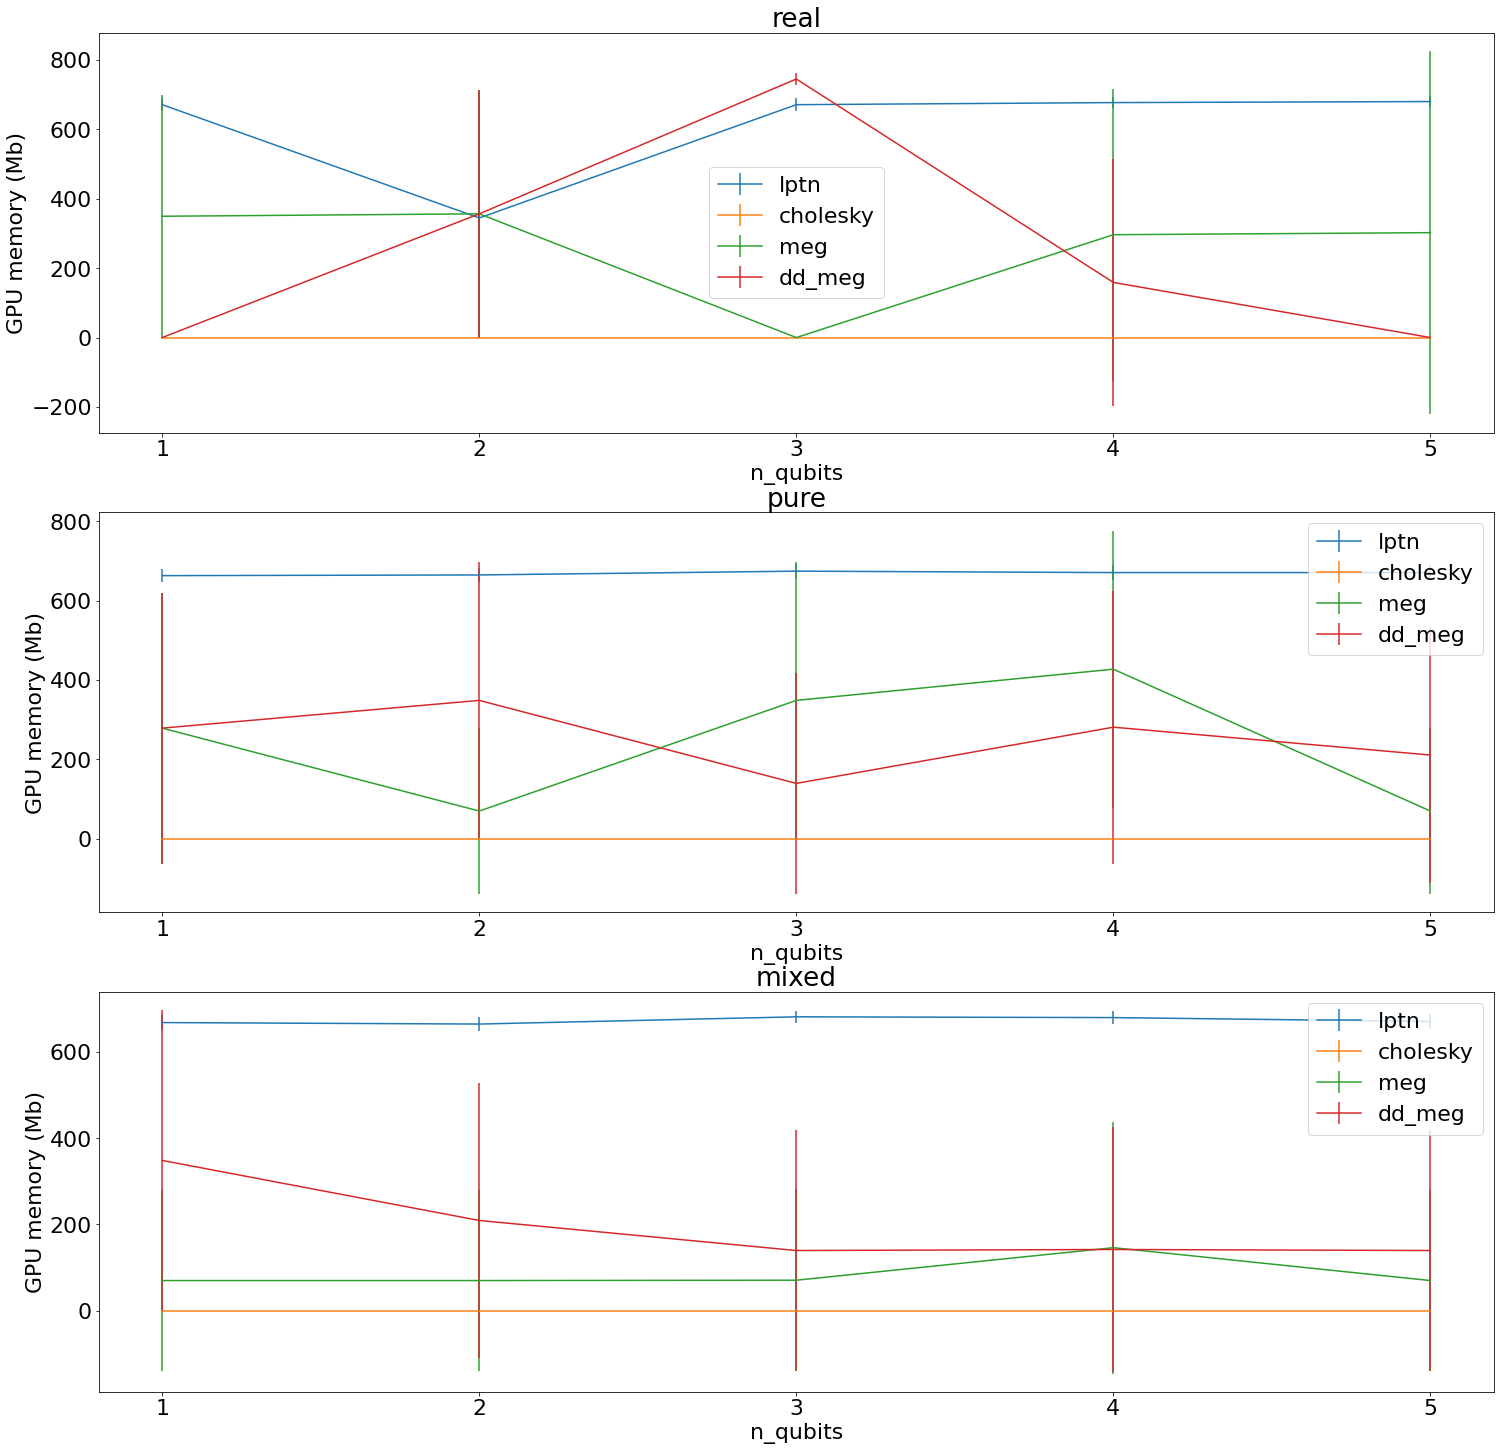

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            gpu_mem = np.array([[x.get('gpu_mem', 0) if not x.get('gpu_mem', 0) is None else 0 for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                gpu_mem = gpu_mem[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(gpu_mem), np.std(gpu_mem)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("GPU memory (Mb)")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

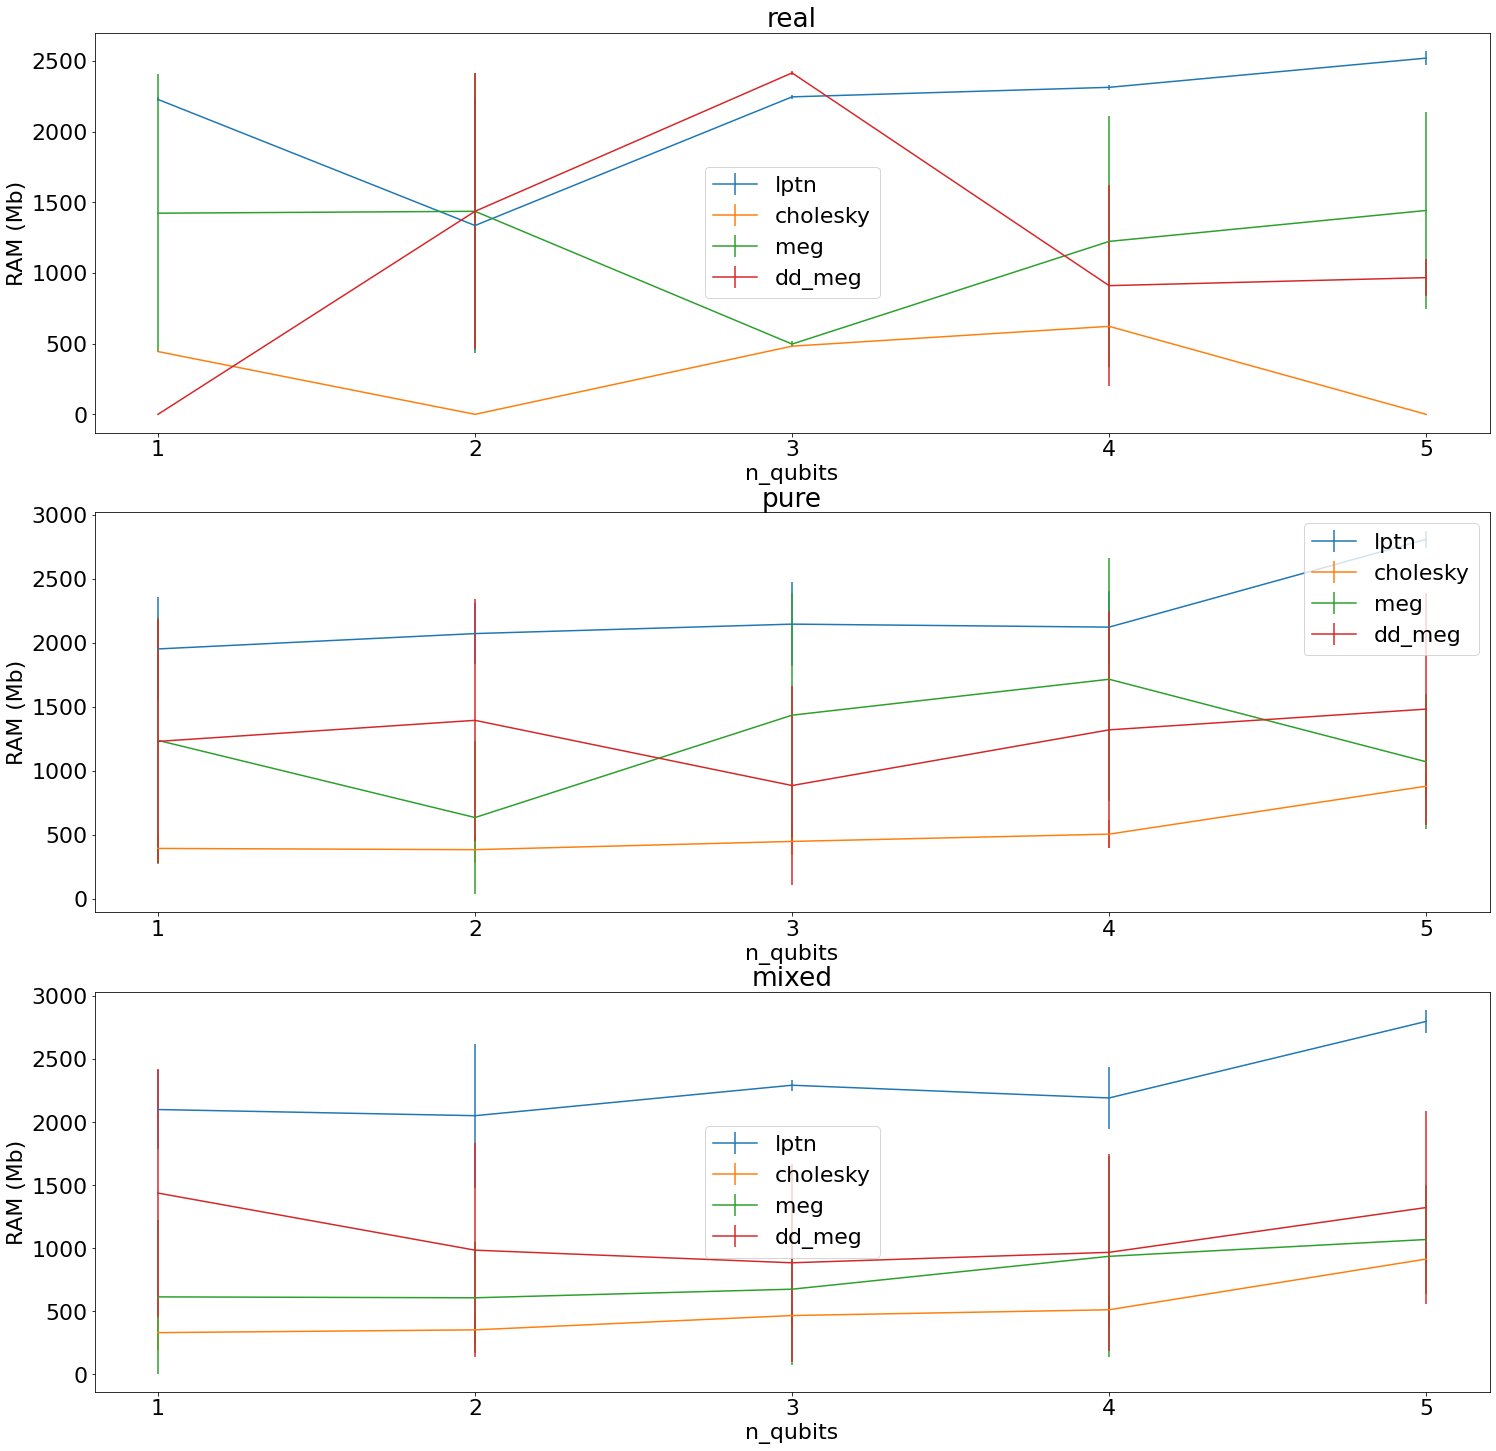

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

qubits_range = list(range(1, 6))

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            gpu_mem = np.array([[x.get('ram_mem', 0) if not x.get('ram_mem', 0) is None else 0 for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                gpu_mem = gpu_mem[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(gpu_mem), np.std(gpu_mem)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("RAM (Mb)")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

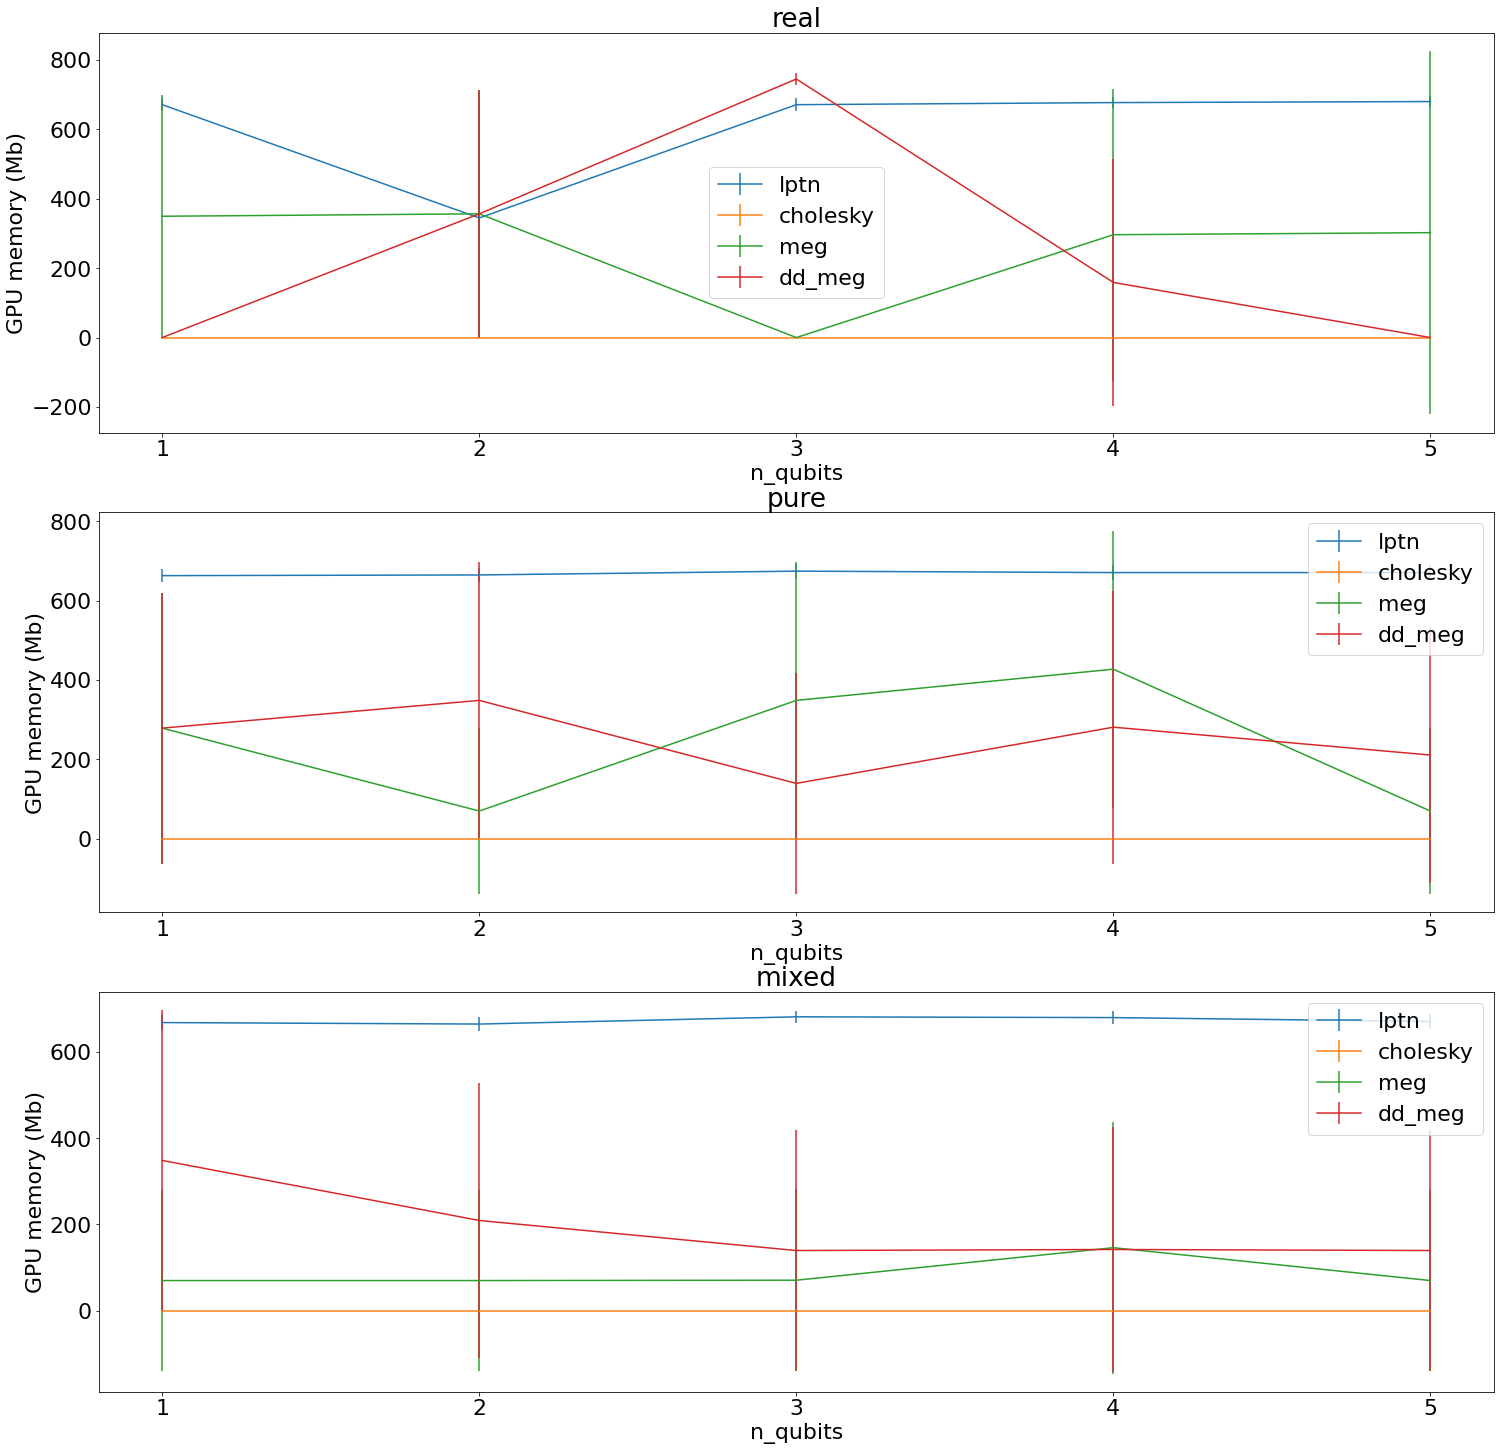

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25,25))
plt.rcParams.update({'font.size': 22})

qubits_range = list(range(1, 6))

for i, data_type in enumerate(['real', 'pure', 'mixed']):
    algorithms = {'lptn': [], 'cholesky': [], 'meg': [], 'dd_meg': []}
    for algorithm in algorithms:
        for n_qubits in qubits_range:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            
            if len(task_ids) == 0: 
                algorithms[algorithm].append((0,0))
                continue
            gpu_mem = np.array([[x.get('gpu_mem', 0) if not x.get('gpu_mem', 0) is None else 0 for x in read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))['results']] for tid in task_ids])
            if algorithm == 'lptn':
                tensor_ranks = np.array([tasks[tid]['tensor_rank'] for tid in task_ids])
                gpu_mem = gpu_mem[tensor_ranks == max(tensor_ranks)]
            algorithms[algorithm].append((np.mean(gpu_mem), np.std(gpu_mem)))
    plt.subplot(3,1,i+1)
    plt.title(f'{data_type}')
    for algorithm_name, values in algorithms.items():
        plt.errorbar(qubits_range, [x[0] for x in values], yerr=[x[1] for x in values], label=algorithm_name)
        plt.xticks(qubits_range)
        plt.xlabel('n_qubits')
        plt.ylabel("GPU memory (Mb)")
#         plt.ylim((0,1))
#         plt.yscale('log')
    plt.legend()

## Кросс-валидация на трейне и тесте

<ipython-input-67-9c66adf05f04>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(rows_cnt, 1, i)


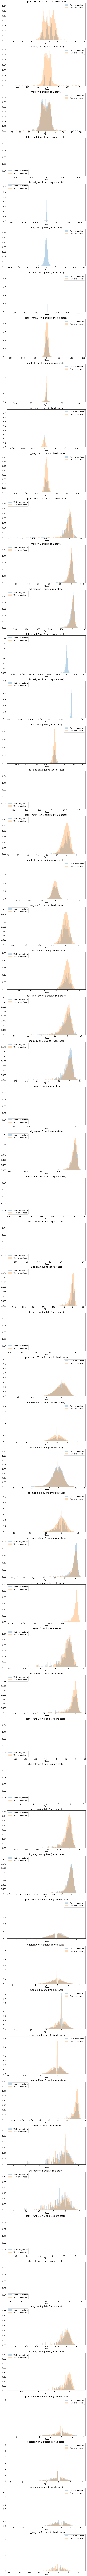

In [67]:
rows_cnt = len(qubits_range)*len(['real', 'pure', 'mixed'])*len(['lptn', 'cholesky', 'meg', 'dd_meg'])
plt.figure(figsize=(17,10*rows_cnt))
i = 1
for n_qubits in qubits_range:
    for data_type in ['real', 'pure', 'mixed']:
        for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
            plt.subplot(rows_cnt, 1, i)
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            fidelities = []
            for tid in task_ids:
                res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
                fidelities.append(max([v for r in res['results'] for v in r['fidelities']]))
            if not fidelities: continue
            best_task_id = task_ids[np.argmax(fidelities)]
            res = read_json(os.path.join(RESULTS_DIR, f'{best_task_id}.json'))
            algorithm_name = algorithm
            if algorithm == 'lptn':
                algorithm_name = f'{algorithm_name} - rank {tasks[best_task_id]["tensor_rank"]}'
            def tolist(vals):
                if isinstance(vals, list): return vals
                return [vals]
            ttest_train, ttest_test = [[v for r in res['results'] for v in tolist(r[test]) if not np.isinf(v)] for test in ['ttest_train', 'ttest_test']]
            plt.hist(ttest_train, weights=np.ones_like(ttest_train)*100./sum([abs(x) for x in ttest_train]), label='Train projectors', bins=1000, alpha=0.3)
            plt.hist(ttest_test, weights=np.ones_like(ttest_test)*100./sum([abs(x) for x in ttest_test]), label='Test projectors', bins=1000, alpha=0.3)
            plt.legend()
            plt.xlabel('T-test')
            plt.title(f'{algorithm_name} on {tasks[best_task_id]["n_qubits"]} qubits ({data_type} state)');
            i += 1

## Зависимость от размера обуч выборки (числа проекторов)

In standard scale

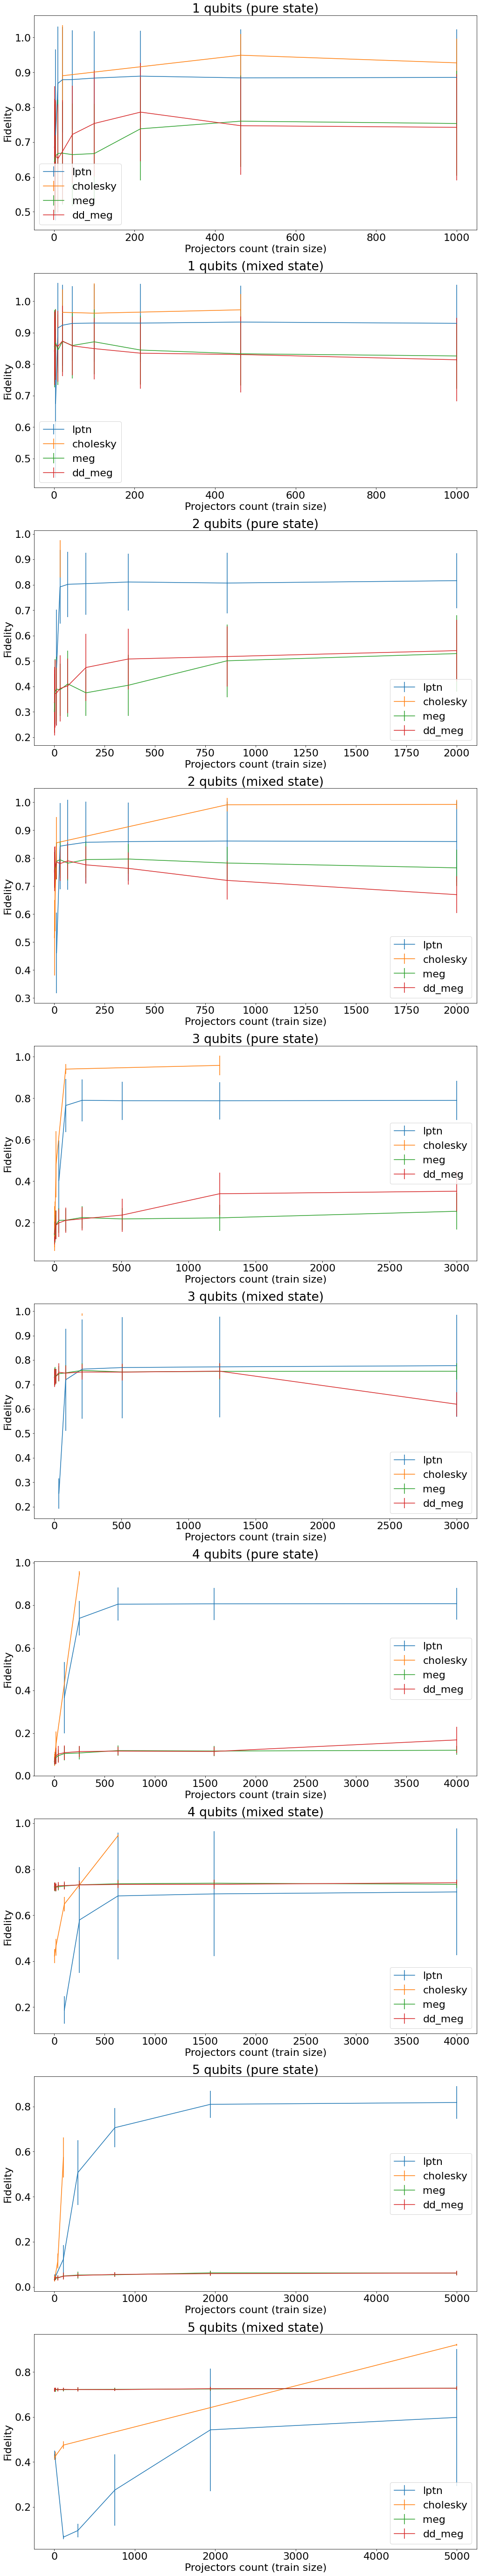

In [86]:
from collections import defaultdict
rows_cnt = len(qubits_range)*len(['pure', 'mixed'])
plt.figure(figsize=(17,10*rows_cnt))
i = 0
for n_qubits in qubits_range:
    for data_type in ['pure', 'mixed']:
        i += 1
        plt.subplot(rows_cnt, 1, i)
        plt.title(f'{n_qubits} qubits ({data_type} state)');
        for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            fidelities = defaultdict(list)
            for tid in task_ids:
                res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
                projectors_cnt = tasks[tid]['projectors_cnt']
                for r in res['results']:
                    fidelities[projectors_cnt].append(max([v for v in r['fidelities']]))
            if not len(task_ids): continue
            projectors_cnt = list(sorted(fidelities.keys()))
#             plt.plot(x, y, label=algorithm)

            _, caps, _ = plt.errorbar(projectors_cnt, 
                         [np.mean(fidelities[proj_cnt]) for proj_cnt in projectors_cnt], 
                         [np.std(fidelities[proj_cnt]) for proj_cnt in projectors_cnt], 
                         label=algorithm)
            for cap in caps:
                cap.set_markeredgewidth(1)

#             plt.yscale('log')
        plt.legend()
        plt.ylabel('Fidelity')
        plt.xlabel('Projectors count (train size)')

In log scale

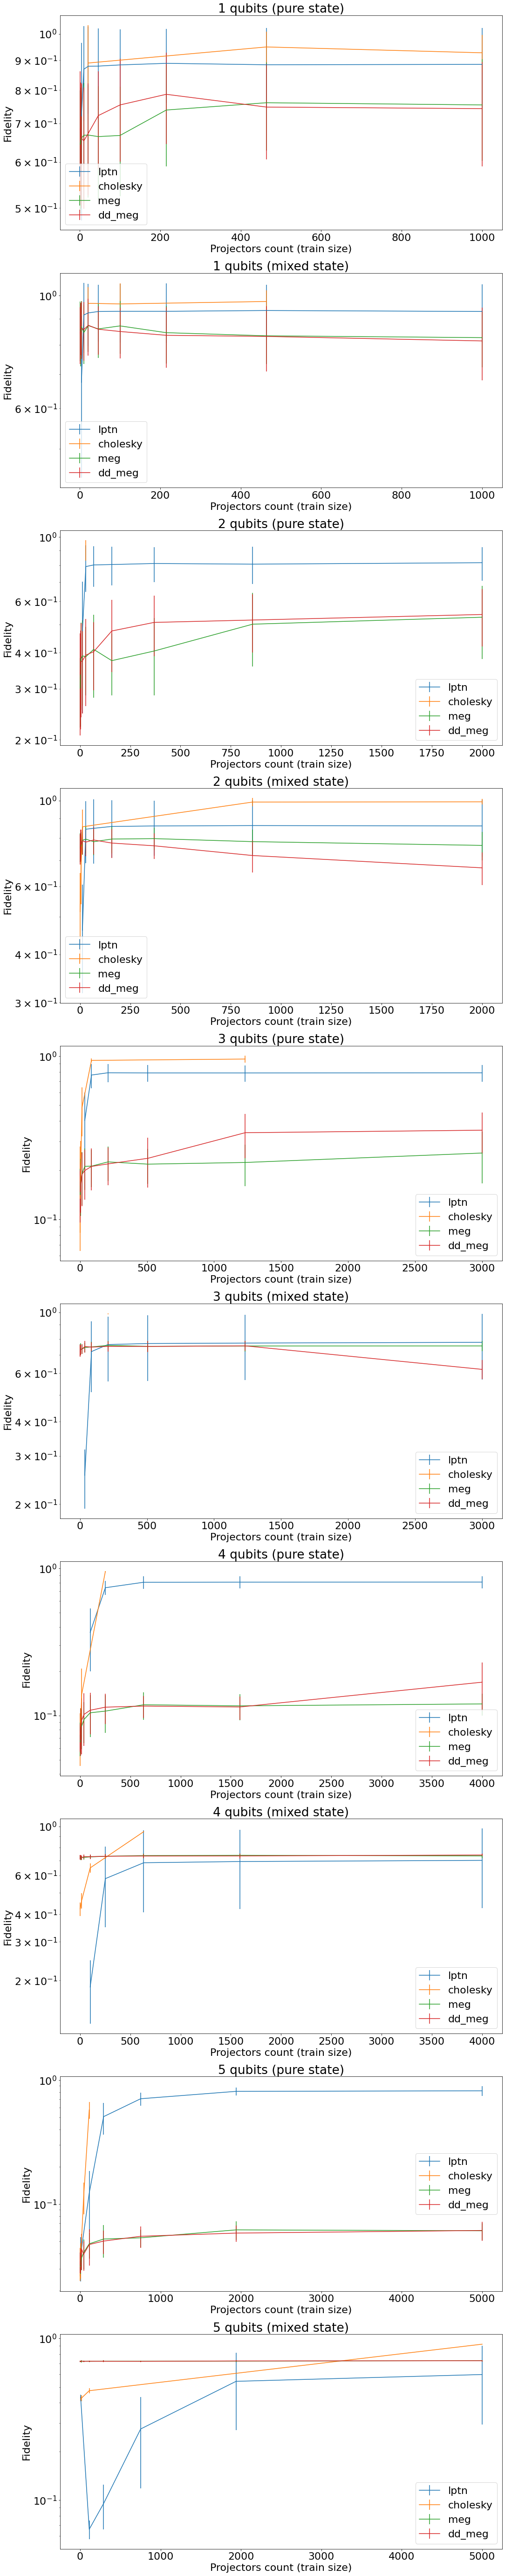

In [87]:
from collections import defaultdict
rows_cnt = len(qubits_range)*len(['pure', 'mixed'])
plt.figure(figsize=(17,10*rows_cnt))
i = 0
for n_qubits in qubits_range:
    for data_type in ['pure', 'mixed']:
        i += 1
        plt.subplot(rows_cnt, 1, i)
        plt.title(f'{n_qubits} qubits ({data_type} state)');
        for algorithm in ['lptn', 'cholesky', 'meg', 'dd_meg']:
            task_ids = query_job_ids(algorithm, data_type, n_qubits)
            fidelities = defaultdict(list)
            for tid in task_ids:
                res = read_json(os.path.join(RESULTS_DIR, f'{tid}.json'))
                projectors_cnt = tasks[tid]['projectors_cnt']
                for r in res['results']:
                    fidelities[projectors_cnt].append(max([v for v in r['fidelities']]))
            if not len(task_ids): continue
            projectors_cnt = list(sorted(fidelities.keys()))
#             plt.plot(x, y, label=algorithm)
            plt.errorbar(projectors_cnt, 
                         [np.mean(fidelities[proj_cnt]) for proj_cnt in projectors_cnt], 
                         [np.std(fidelities[proj_cnt]) for proj_cnt in projectors_cnt],
                         label=algorithm)
            plt.yscale('log')
        plt.legend()
        plt.ylabel('Fidelity')
        plt.xlabel('Projectors count (train size)')